In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os.path
path = "/Users/lsesp/"

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


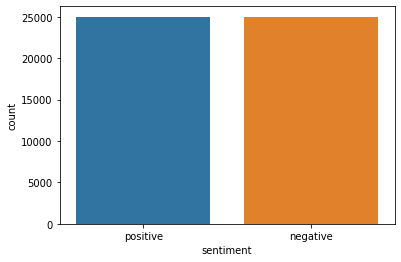

In [12]:
import tensorflow as tf
import sklearn
from tqdm import tqdm
import seaborn as sns


df=pd.read_csv("IMDB Dataset/IMDB Dataset.csv")

sns.countplot(x=df["sentiment"])

df.head()
#df.sentiment.value_counts().plot(kind="bar")


In [4]:

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

checkpoint_path= "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path)

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

model.save_pretrained(checkpoint_path, verbose = 1, save_weights_only = True)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# changing positive and negative into numeric values

def cat2num(value):
    if value=='positive': 
        return 1
    else: 
        return 0
    
df['sentiment']  =  df['sentiment'].apply(cat2num)
train = df[:45000]
test = df[45000:]

# Data Preprocessing


In [6]:
# But first see BERT tokenizer exmaples and other required stuff!

example='Currently enjoying pinocchio pretty good film'
tokens=tokenizer.tokenize(example)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(token_ids)

['currently', 'enjoying', 'pin', '##oc', '##chio', 'pretty', 'good', 'film']
[2747, 9107, 9231, 10085, 23584, 3492, 2204, 2143]


In [16]:
def convert_data_to_examples(train, test, review, sentiment): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[review], 
                                                          label = x[sentiment]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[review], 
                                                          label = x[sentiment]), axis = 1,)
  
    return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train,  test, 'review',  'sentiment')
                                                                         

In [18]:
#train_InputExamples[0]

In [9]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in tqdm(examples):
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,    # Add 'CLS' and 'SEP'
            max_length=max_length,    # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],input_dict["token_type_ids"], input_dict['attention_mask'])
        features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label) )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'review'
LABEL_COLUMN = 'sentiment'

In [10]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

  0%|          | 0/45000 [00:00<?, ?it/s]C:\Users\lsesp\anaconda3\envs\proyectos\lib\site-packages\transformers\tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 45000/45000 [04:42<00:00, 159.47it/s]


In [11]:
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

100%|██████████| 5000/5000 [00:31<00:00, 158.02it/s]


<font size="4">Nuestro conjunto de datos que contiene secuencias de entrada procesadas está listo para alimentar el modelo.<font size="4">

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data, callbacks = [cp_callback])

Epoch 1/2
   2814/Unknown - 2265s 795ms/step - loss: 0.2418 - accuracy: 0.8988

INFO:tensorflow:Assets written to: training\cp.ckpt\assets


INFO:tensorflow:Assets written to: training\cp.ckpt\assets


2814/2814 [==============================] - 2351s 826ms/step - loss: 0.2418 - accuracy: 0.8988 - val_loss: 0.2938 - val_accuracy: 0.8964
Epoch 2/2
2814/2814 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9750

INFO:tensorflow:Assets written to: training\cp.ckpt\assets


INFO:tensorflow:Assets written to: training\cp.ckpt\assets



2814/2814 [==============================] - 2637s 937ms/step - loss: 0.0719 - accuracy: 0.9750 - val_loss: 0.4321 - val_accuracy: 0.8846


<font size=4>PRUEBA DEL MODELO ENTRENADO<font size=4>

In [ ]:
pred_sentences = [
                   "this is one of the best things i’ve ever seen in my life",
                    "Here’s the thing, though: Cats still makes no f.cking sense."
                 ]

In [15]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model
tf_outputs = model(tf_batch)                                  
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       # axis=-1, this means that the index that will be returned by argmax will be taken from the *last* axis.
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", labels[label[i]])

worst movie of my life, will never watch movies from this series :  Negative
Wow, blew my mind, what a movie by Marvel, animation and story is amazing :  Positive


<font size=4>PRUEBA DEL MODELO ENTRENADO USANDO LOS PESOS GUARDADOS PREVIO (requiere lineas anteriores)<font size=4>

In [16]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [7]:
savedModel =  TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
savedModel.load_weights(checkpoint_path)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
pred_sentences = [
                   "this is one of the best things i’ve ever seen in my life",
                    "Here’s the thing, though: Cats still makes no f.cking sense."
                 ]

In [24]:
savedModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

tf_batch2 = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model
tf_outputs2 = model(tf_batch2)                                  
tf_predictions2 = tf.nn.softmax(tf_outputs2[0], axis=-1)       # axis=-1, this means that the index that will be returned by argmax will be taken from the *last* axis.
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions2, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", labels[label[i]])


this is one of the best things i’ve ever seen in my piece of shit life :  Negative
Here’s the thing, though: Cats still makes no f.cking sense. :  Negative
